### Bert Base Cased ###

Train and evaluate on selfMA dataset balanced with Toxigen.

In [ ]:
!pip install -q transformers
!pip install -q torchinfo
!pip install -U -q datasets
!pip install -q evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from datasets import load_from_disk
import random
import pandas as pd
import numpy as np
import evaluate
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
balanced_selfMA_ds = load_from_disk("/content/drive/MyDrive/266_project/balanced_selfMA_ds_toxigen_quote")
random.seed(42)

max_sequence_length = 128

def preprocess_data(data, tokenizer):
    # Ensure text is a list of strings
    text = data['text']
    encoded = tokenizer.batch_encode_plus(
            text,
            max_length=max_sequence_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=True
            # return_tensors="pt"
    )
    return encoded


metric = evaluate.load('accuracy')
f1  = evaluate.load("f1")

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)
    return {
        **metric.compute(predictions=predictions, references=labels),
        "f1_macro": f1.compute(predictions=predictions, references=labels, average="macro")["f1"],
    }

In [ ]:
def fine_tune_classification_model(classification_model,
                                   tokenizer,
                                   train_data,
                                   dev_data,
                                   batch_size = 16,
                                   num_epochs = 3,
                                   learning_rate=2e-5):
    """
    Preprocess the data using the given tokenizer (we've give you the code for that part).
    Create the training arguments and trainer for the given model and data (write your code for that).
    Then train it.
    """

    preprocessed_train_data = train_data.map(preprocess_data, batched=True, fn_kwargs={'tokenizer': tokenizer})
    preprocessed_dev_data = dev_data.map(preprocess_data, batched=True, fn_kwargs={'tokenizer': tokenizer})

    # Referencing lesson 4 notebook & assignment 2 as an example:
    training_args = TrainingArguments(
      output_dir="bert_selfMA_balanced",
      per_device_train_batch_size=batch_size,
      per_device_eval_batch_size=batch_size,
      num_train_epochs=num_epochs,
      learning_rate=learning_rate,
      eval_strategy="epoch",
      save_strategy="epoch",
      report_to='none',
      load_best_model_at_end = True,
      metric_for_best_model = "f1_macro",
      seed = 42
    )

    trainer = Trainer(
      model=classification_model,
      args=training_args,
      train_dataset=preprocessed_train_data,
      eval_dataset=preprocessed_dev_data,
      compute_metrics=compute_metrics
    )

    trainer.train()

    return trainer

In [ ]:
model_checkpoint_name = "bert-base-cased"
bert_tokenizer = AutoTokenizer.from_pretrained(model_checkpoint_name)
bert_classification_model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint_name, num_labels = 3)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
bert_base_cased_trainer = fine_tune_classification_model(bert_classification_model, bert_tokenizer, balanced_selfMA_ds['train'], balanced_selfMA_ds['validation'])

Map:   0%|          | 0/3120 [00:00<?, ? examples/s]

Map:   0%|          | 0/390 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,0.294968,0.887179,0.886355
2,No log,0.227276,0.938462,0.938386
3,0.323800,0.246403,0.930769,0.930387


In [ ]:
preprocessed_test_data = balanced_selfMA_ds['test'].map(preprocess_data, batched=True, fn_kwargs={'tokenizer': bert_tokenizer})
predictions = bert_base_cased_trainer.predict(preprocessed_test_data)
preprocessed_test_pred_bert_base = np.argmax(predictions.predictions, axis=1)
y_true_bert_base = balanced_selfMA_ds['test']['label']
from sklearn.metrics import accuracy_score, classification_report

test_accuracy_bert_base = accuracy_score(y_true_bert_base, preprocessed_test_pred_bert_base)
print(f"\nTest Accuracy: {test_accuracy_bert_base:.4f}")
print("\nClassification Report:")
print(classification_report(y_true_bert_base, preprocessed_test_pred_bert_base, target_names=['0: Non-aggressive/normal text', '1: Microaggression', '2: Explicit aggression/toxic']))

Map:   0%|          | 0/390 [00:00<?, ? examples/s]


Test Accuracy: 0.8077

Classification Report:
                               precision    recall  f1-score   support

0: Non-aggressive/normal text       0.83      0.82      0.83       130
           1: Microaggression       0.78      0.98      0.87       130
 2: Explicit aggression/toxic       0.82      0.62      0.70       130

                     accuracy                           0.81       390
                    macro avg       0.81      0.81      0.80       390
                 weighted avg       0.81      0.81      0.80       390



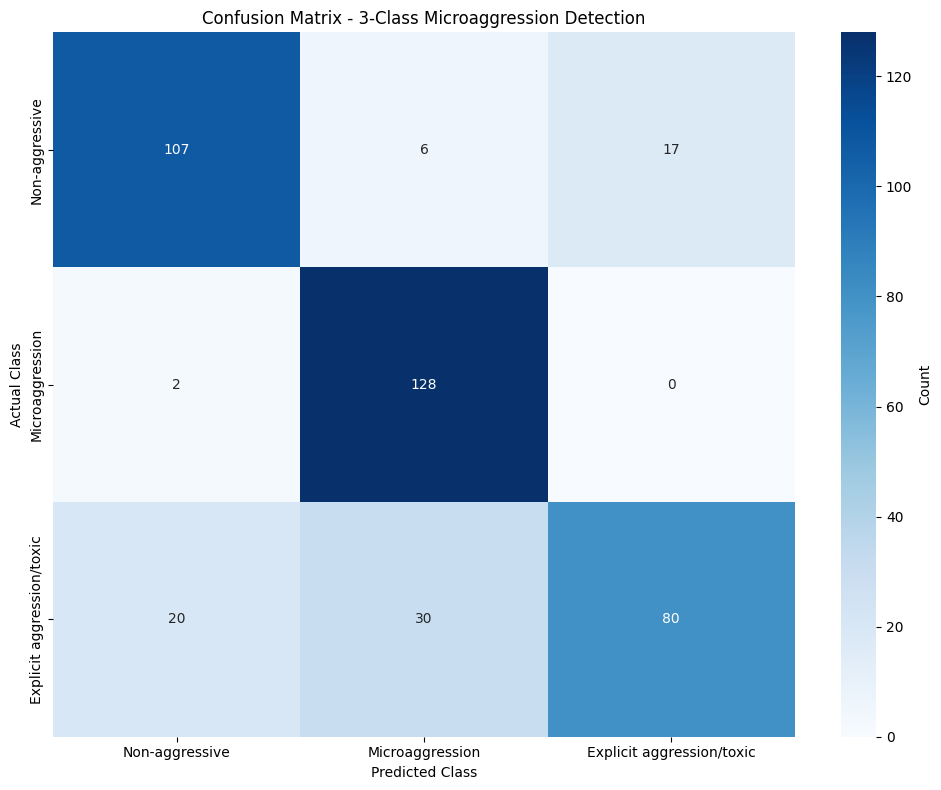

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true_bert_base, preprocessed_test_pred_bert_base)
class_names = ['Non-aggressive', 'Microaggression', 'Explicit aggression/toxic']

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.title('Confusion Matrix - 3-Class Microaggression Detection')
plt.tight_layout()
plt.show()

### Hate Bert ###

In [ ]:
model_checkpoint_name = "GroNLP/hateBERT"
hatebert_tokenizer = AutoTokenizer.from_pretrained(model_checkpoint_name)
hatebert_classification_model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint_name, num_labels = 3)

tokenizer_config.json:   0%|          | 0.00/151 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
hatebert_trainer = fine_tune_classification_model(hatebert_classification_model, hatebert_tokenizer, balanced_selfMA_ds['train'], balanced_selfMA_ds['validation'])

Map:   0%|          | 0/3120 [00:00<?, ? examples/s]

Map:   0%|          | 0/390 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,0.348391,0.864103,0.862721
2,No log,0.295796,0.907692,0.906978
3,0.359300,0.314416,0.905128,0.904398


In [ ]:
preprocessed_test_data = balanced_selfMA_ds['test'].map(preprocess_data, batched=True, fn_kwargs={'tokenizer': hatebert_tokenizer})
predictions = hatebert_trainer.predict(preprocessed_test_data)
preprocessed_test_pred_hatebert = np.argmax(predictions.predictions, axis=1)
y_true_hatebert = balanced_selfMA_ds['test']['label']
from sklearn.metrics import accuracy_score, classification_report

test_accuracy_hatebert = accuracy_score(y_true_hatebert, preprocessed_test_pred_hatebert)
print(f"\nTest Accuracy: {test_accuracy_hatebert:.4f}")
print("\nClassification Report:")
print(classification_report(y_true_hatebert, preprocessed_test_pred_hatebert, target_names=['0: Non-aggressive/normal text', '1: Microaggression', '2: Explicit aggression/toxic']))

Map:   0%|          | 0/390 [00:00<?, ? examples/s]


Test Accuracy: 0.7846

Classification Report:
                               precision    recall  f1-score   support

0: Non-aggressive/normal text       0.88      0.76      0.82       130
           1: Microaggression       0.72      0.96      0.82       130
 2: Explicit aggression/toxic       0.79      0.63      0.70       130

                     accuracy                           0.78       390
                    macro avg       0.80      0.78      0.78       390
                 weighted avg       0.80      0.78      0.78       390



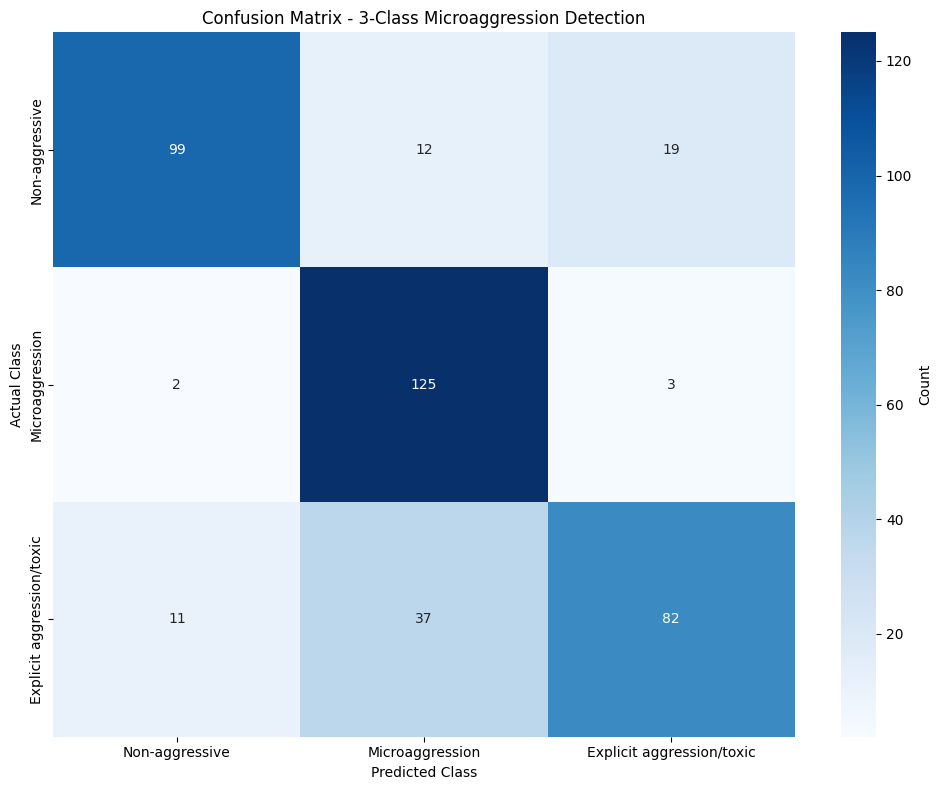

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true_hatebert, preprocessed_test_pred_hatebert)
class_names = ['Non-aggressive', 'Microaggression', 'Explicit aggression/toxic']

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.title('Confusion Matrix - 3-Class Microaggression Detection')
plt.tight_layout()
plt.show()

### RoBERTa Base ###

In [ ]:
model_checkpoint_name = "roberta-base"
roberta_tokenizer = AutoTokenizer.from_pretrained(model_checkpoint_name)
roberta_classification_model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint_name, num_labels = 3)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
roberta_trainer = fine_tune_classification_model(roberta_classification_model, roberta_tokenizer, balanced_selfMA_ds['train'], balanced_selfMA_ds['validation'])

Map:   0%|          | 0/3120 [00:00<?, ? examples/s]

Map:   0%|          | 0/390 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,0.251867,0.915385,0.914807
2,No log,0.208574,0.948718,0.948585
3,0.290100,0.234426,0.943590,0.943374


In [ ]:
preprocessed_test_data = balanced_selfMA_ds['test'].map(preprocess_data, batched=True, fn_kwargs={'tokenizer': roberta_tokenizer})
predictions = roberta_trainer.predict(preprocessed_test_data)
preprocessed_test_pred_roberta = np.argmax(predictions.predictions, axis=1)
y_true_roberta = balanced_selfMA_ds['test']['label']
from sklearn.metrics import accuracy_score, classification_report

test_accuracy_roberta = accuracy_score(y_true_roberta, preprocessed_test_pred_roberta)
print(f"\nTest Accuracy: {test_accuracy_roberta:.4f}")
print("\nClassification Report:")
print(classification_report(y_true_roberta, preprocessed_test_pred_roberta, target_names=['0: Non-aggressive/normal text', '1: Microaggression', '2: Explicit aggression/toxic']))

Map:   0%|          | 0/390 [00:00<?, ? examples/s]


Test Accuracy: 0.8051

Classification Report:
                               precision    recall  f1-score   support

0: Non-aggressive/normal text       0.90      0.78      0.83       130
           1: Microaggression       0.75      0.98      0.85       130
 2: Explicit aggression/toxic       0.79      0.66      0.72       130

                     accuracy                           0.81       390
                    macro avg       0.81      0.81      0.80       390
                 weighted avg       0.81      0.81      0.80       390



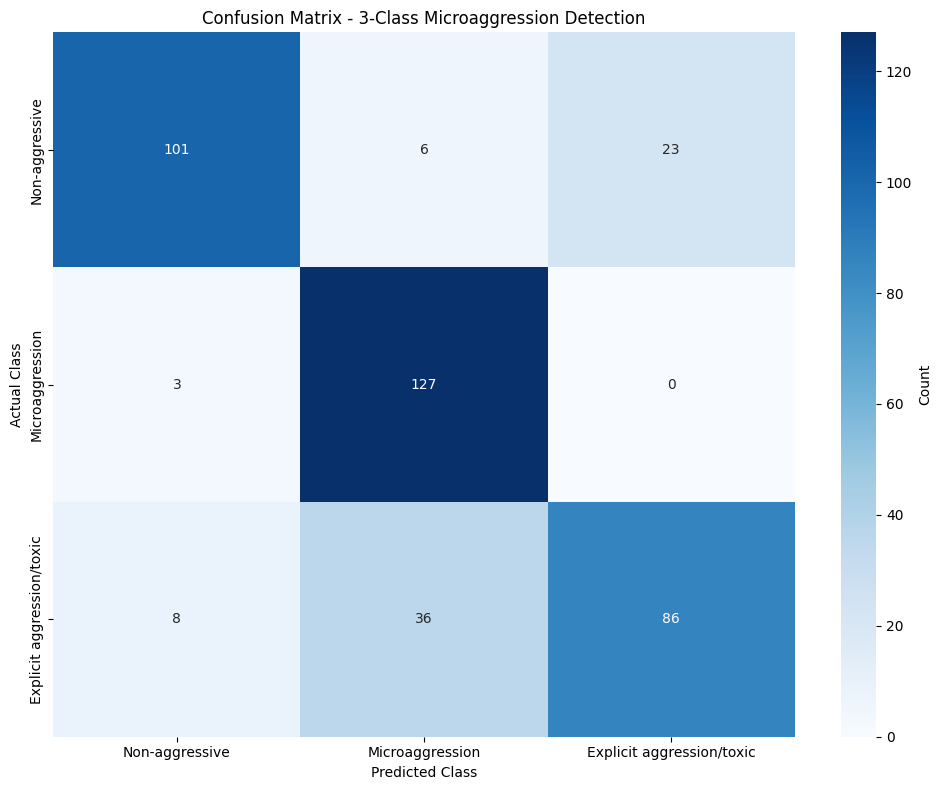

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true_roberta, preprocessed_test_pred_roberta)
class_names = ['Non-aggressive', 'Microaggression', 'Explicit aggression/toxic']

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.title('Confusion Matrix - 3-Class Microaggression Detection')
plt.tight_layout()
plt.show()

### DeBERTa Base ###

In [ ]:
model_checkpoint_name = "microsoft/deberta-v3-base"
deberta_tokenizer = AutoTokenizer.from_pretrained(model_checkpoint_name)
deberta_classification_model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint_name, num_labels = 3)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
deberta_trainer = fine_tune_classification_model(deberta_classification_model, deberta_tokenizer, balanced_selfMA_ds['train'], balanced_selfMA_ds['validation'])

Map:   0%|          | 0/3120 [00:00<?, ? examples/s]

Map:   0%|          | 0/390 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,0.233020,0.923077,0.922070
2,No log,0.197407,0.938462,0.938056
3,0.291700,0.240661,0.946154,0.945945


In [ ]:
preprocessed_test_data = balanced_selfMA_ds['test'].map(preprocess_data, batched=True, fn_kwargs={'tokenizer': deberta_tokenizer})
predictions = deberta_trainer.predict(preprocessed_test_data)
preprocessed_test_pred_deberta = np.argmax(predictions.predictions, axis=1)
y_true_deberta = balanced_selfMA_ds['test']['label']
from sklearn.metrics import accuracy_score, classification_report

test_accuracy_deberta = accuracy_score(y_true_deberta, preprocessed_test_pred_deberta)
print(f"\nTest Accuracy: {test_accuracy_deberta:.4f}")
print("\nClassification Report:")
print(classification_report(y_true_deberta, preprocessed_test_pred_deberta, target_names=['0: Non-aggressive/normal text', '1: Microaggression', '2: Explicit aggression/toxic']))

Map:   0%|          | 0/390 [00:00<?, ? examples/s]


Test Accuracy: 0.8154

Classification Report:
                               precision    recall  f1-score   support

0: Non-aggressive/normal text       0.88      0.86      0.87       130
           1: Microaggression       0.73      0.99      0.84       130
 2: Explicit aggression/toxic       0.90      0.59      0.71       130

                     accuracy                           0.82       390
                    macro avg       0.84      0.82      0.81       390
                 weighted avg       0.84      0.82      0.81       390



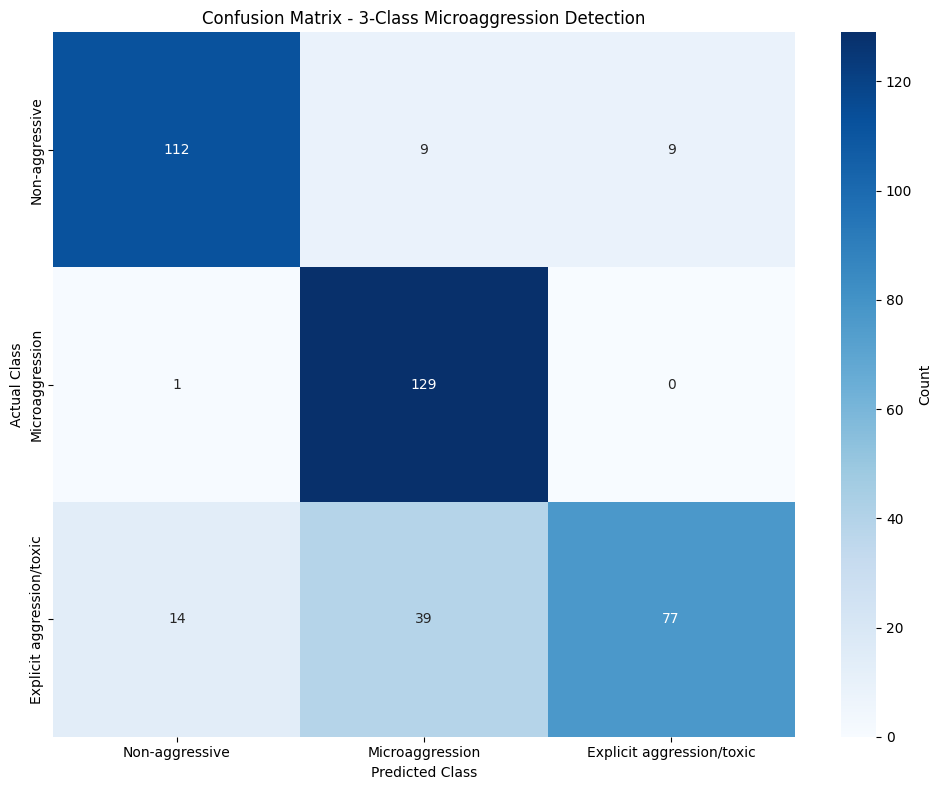

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true_deberta, preprocessed_test_pred_deberta)
class_names = ['Non-aggressive', 'Microaggression', 'Explicit aggression/toxic']

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.title('Confusion Matrix - 3-Class Microaggression Detection')
plt.tight_layout()
plt.show()